## Libraries and Dependencies

In [47]:
import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import norm
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [48]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [49]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1 #神经网络的层数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #激活函数为tanh
        
        layer_list = list() # 创建一个空列表 layer_list，用于存储神经网络的层和激活函数。
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        ) # 向 layer_list 添加输出层
        layerDict = OrderedDict(layer_list) #存储按顺序排列的层和激活函数
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [50]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, sigma, r):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.S_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.S_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.sigma = sigma
        self.r = r
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.loss_history = []
        self.time_history = []
        
    def net_u(self, S, t):  
        u = self.dnn(torch.cat([S, t], dim=1)) # dim = 1 :按行并排
        return u
    
    def net_f(self, S, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(S, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_S = torch.autograd.grad(
            u, S, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_SS = torch.autograd.grad(
            u_S, S, 
            grad_outputs=torch.ones_like(u_S),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + 0.5 * self.sigma**2 * S**2 * u_SS + self.r * S * u_S - self.r * u
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.S_u, self.t_u)
        f_pred = self.net_f(self.S_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        self.loss_history.append(loss.item())
        self.time_history.append(time.time())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        S = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [51]:
# Exact solution (Black-Scholes formula for European call option)
def black_scholes(S, K, T, t, r, sigma):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

## Configurations

In [53]:
# Parameters for Black-Scholes equation
sigma = 0.2
r = 0.05
T = 1.0  # 到期时间
K = 50  # 执行价格

# Domain bounds for stock price and time
S_min = 0.0
S_max = 100.0
t_min = 0.0
t_max = T

# Generating training data
N_u = 1000  # Number of initial condition points
N_f = 10000  # Number of collocation points

# Initial condition: European Call Option Payoff at t = T
S_0 = np.linspace(S_min, S_max, N_u)[:, None]
t_0 = np.ones((N_u, 1))
u_0 = np.maximum(S_0 - K, 0)

# Collocation points
X_f_train = np.hstack((S_min + (S_max - S_min) * lhs(1, N_f), t_min + (t_max - t_min) * lhs(1, N_f)))

# Combine all training data
X_u_train = np.hstack([S_0, t_0])
u_train = u_0

# Randomly sample initial condition points
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

# Define the neural network structure
layers = [2, 30, 30, 30, 30,30,30, 1]

## Training

In [54]:
# Initialize the Physics Informed Neural Network
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, [S_min, t_min], [S_max, t_max], sigma, r)

In [55]:
# Train the model1q

start_time = time.time()
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Iter 100, Loss: 2.64336e+00, Loss_u: 7.04059e-01, Loss_f: 1.93930e+00
Iter 200, Loss: 5.33146e-01, Loss_u: 3.68610e-01, Loss_f: 1.64536e-01
Iter 300, Loss: 4.70133e-01, Loss_u: 3.63478e-01, Loss_f: 1.06655e-01
Iter 400, Loss: 4.17938e-01, Loss_u: 3.49318e-01, Loss_f: 6.86193e-02
Iter 500, Loss: 3.87313e-01, Loss_u: 3.37506e-01, Loss_f: 4.98075e-02
Iter 600, Loss: 3.13763e-01, Loss_u: 2.44337e-01, Loss_f: 6.94262e-02
Iter 700, Loss: 2.64945e-01, Loss_u: 2.25876e-01, Loss_f: 3.90690e-02
Iter 800, Loss: 2.06270e-01, Loss_u: 1.70306e-01, Loss_f: 3.59640e-02
Iter 900, Loss: 1.77631e-01, Loss_u: 1.32500e-01, Loss_f: 4.51317e-02
Iter 1000, Loss: 1.66350e-01, Loss_u: 1.33296e-01, Loss_f: 3.30540e-02
Iter 1100, Loss: 1.33762e-01, Loss_u: 1.12378e-01, Loss_f: 2.13833e-02
Iter 1200, Loss: 9.44103e-02, Loss_u: 6.00067e-02, Loss_f: 3.44036e-02
Iter 1300, Loss: 9.18274e-02, Loss_u: 5.81192e-02, Loss_f: 3.37081e-02
Iter 1400, Loss: 9.48405e-02, Loss_u: 6.00087e-02, Loss_f: 3.48318e-02
Iter 1500, Loss

In [56]:
# Predict using the trained model
S_star = np.linspace(S_min, S_max, 100)[:, None]
t_star = np.linspace(t_min, t_max, 100)[:, None]
S_star, t_star = np.meshgrid(S_star, t_star)
X_star = np.hstack((S_star.flatten()[:, None], t_star.flatten()[:, None]))

u_pred, f_pred = model.predict(X_star)

# Compute exact solution
u_exact = black_scholes(S_star.flatten(), K, T, t_star.flatten(), r, sigma)

# Compute error
error_u = np.linalg.norm(u_exact - u_pred.flatten(), 2) / np.linalg.norm(u_exact, 2)
print('Error u: %e' % (error_u))

# Reshape predictions and exact solutions for plotting
U_pred = griddata(X_star, u_pred.flatten(), (S_star, t_star), method='cubic')
U_exact = griddata(X_star, u_exact.flatten(), (S_star, t_star), method='cubic')
Error = np.abs(U_exact - U_pred)

Error u: 2.522313e-03


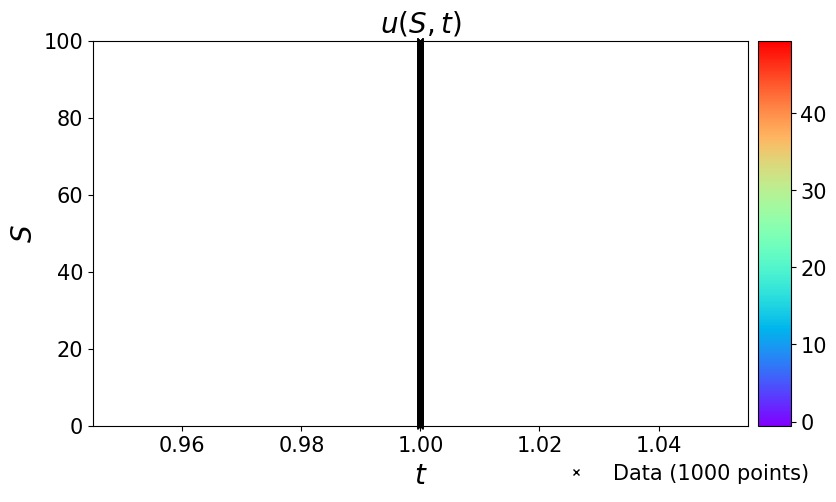

In [40]:

""" The aesthetic setting has changed. """

####### Row 0: u(S,t) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_0.min(), t_0.max(), S_0.min(), S_0.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(t_0.min(), t_0.max(), 2)[:,None]
ax.plot(t_0[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_0[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_0[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(S,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Text(0.5, 1.0, 'Error')

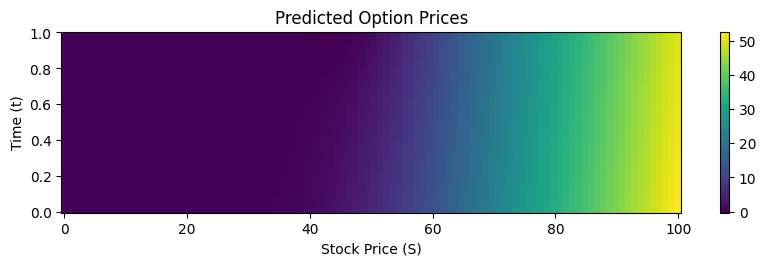

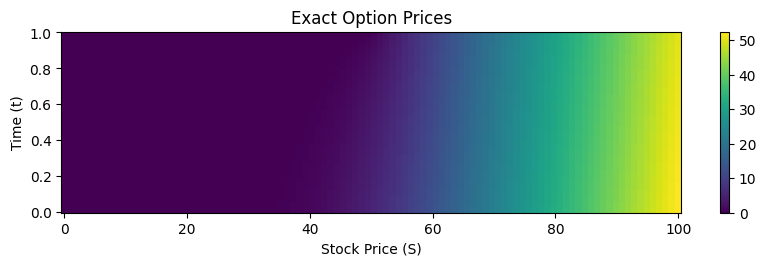

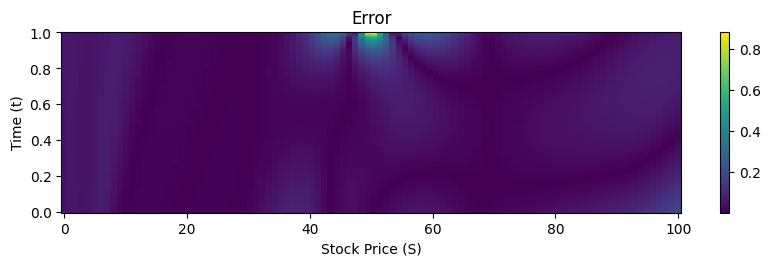

In [58]:
# Plot predicted solution
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.pcolor(S_star, t_star, U_pred, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Predicted Option Prices')

# Plot predicted solution
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.pcolor(S_star, t_star, U_exact, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Exact Option Prices')

# Plot error
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 3)
plt.pcolor(S_star, t_star, Error, shading='auto')
plt.colorbar()
plt.xlabel('Stock Price (S)')
plt.ylabel('Time (t)')
plt.title('Error')

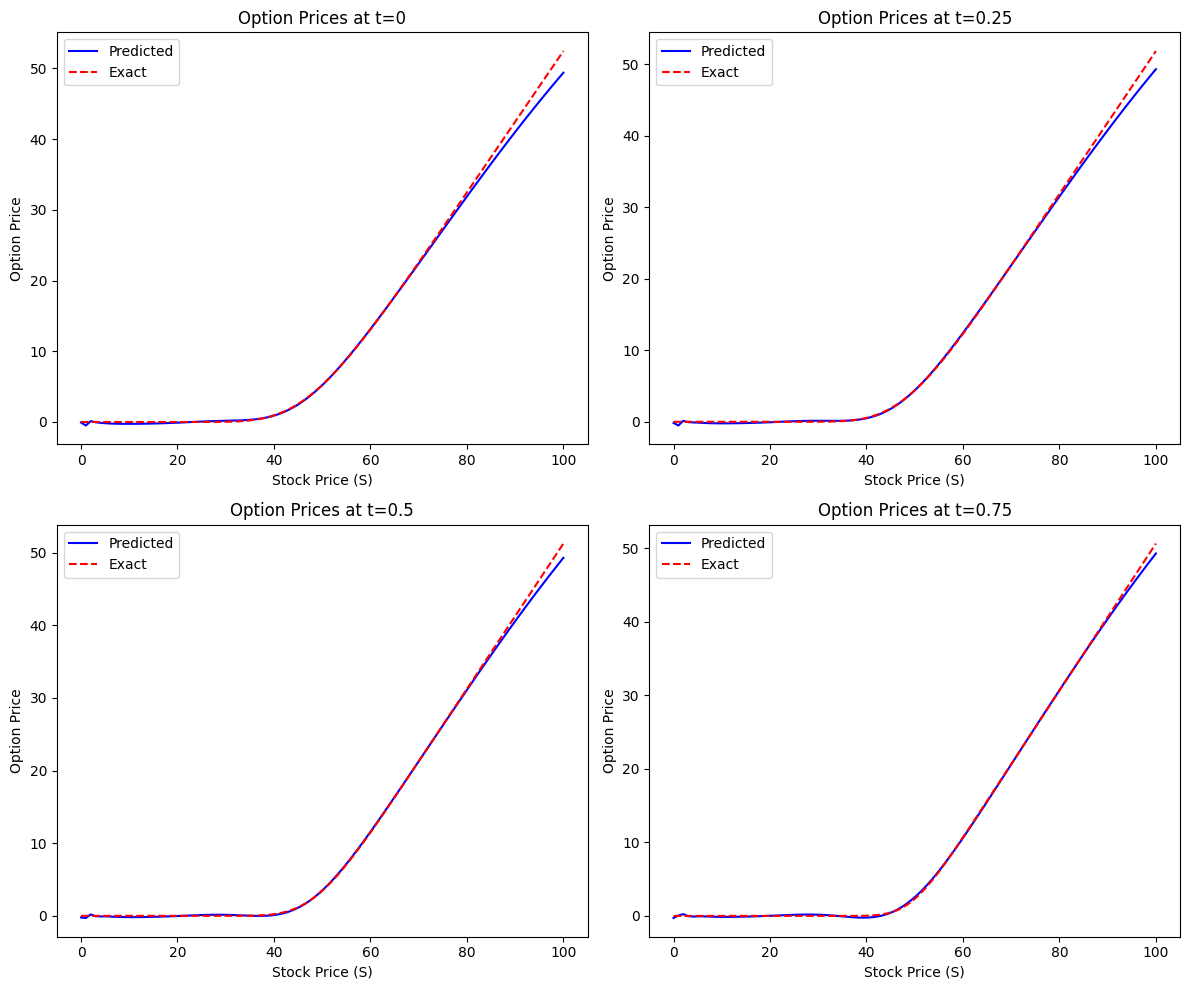

In [42]:
# Predict using the trained model for specific time slices
t_values = [0,0.25, 0.5, 0.75]
S_star = np.linspace(S_min, S_max, 100)[:, None]

plt.figure(figsize=(12, 10))

for i, t_val in enumerate(t_values):
    t_star = t_val * np.ones_like(S_star)
    X_star = np.hstack((S_star, t_star))
    
    u_pred, _ = model.predict(X_star)
    u_exact = black_scholes(S_star.flatten(), K, T, t_star.flatten(), r, sigma)
    
    # Plot predicted and exact option prices in the same plot
    plt.subplot(2, 2, i + 1)
    plt.plot(S_star, u_pred, 'b-', label='Predicted')
    plt.plot(S_star, u_exact, 'r--', label='Exact')
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Price')
    plt.title(f'Option Prices at t={t_val}')
    plt.legend()

plt.tight_layout()
plt.show()

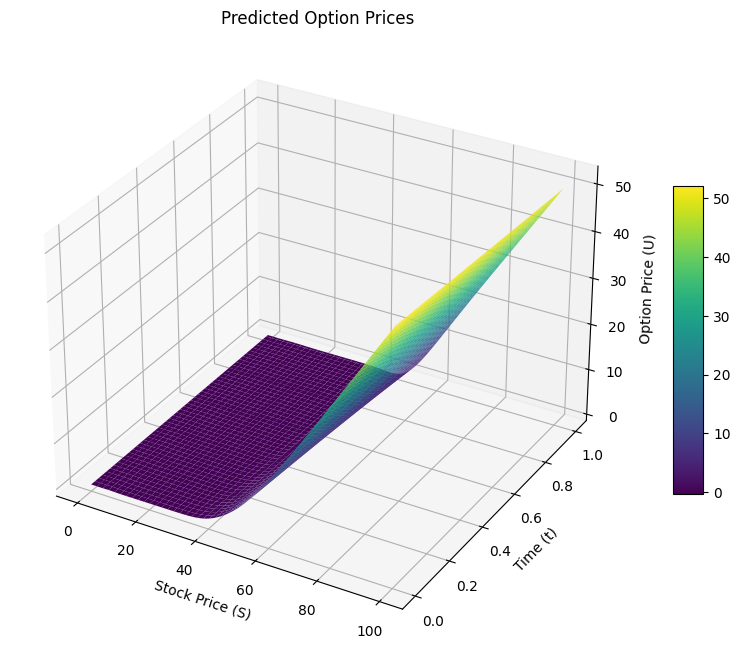

In [60]:
# 创建三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制3D曲面图
surf = ax.plot_surface(S_star, t_star, U_pred, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=10)

# 设置标签和标题
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Option Price (U)')
ax.set_title('Predicted Option Prices')

# 显示图像
plt.show()

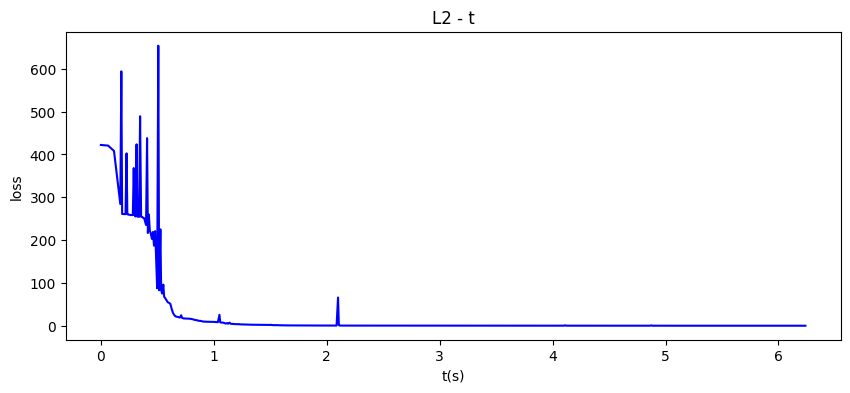

In [43]:
# 绘制损失与时间的关系
plt.figure(figsize=(10, 4))
time_diffs = np.array(model.time_history) - model.time_history[0]
plt.plot(time_diffs, model.loss_history, 'b-')
plt.xlabel('t(s)')
plt.ylabel('loss')
plt.title('L2 - t')
plt.show()